In [1]:
from pylab import *
import h5py
from scipy.optimize import curve_fit
#from scipy.stats import binned_statistic_dd
from lib.analysis_library import vectorized_binned_statistic_dd
import filter_masks
import pickle
from scipy import stats
from sklearn.datasets import make_blobs
import pandas as pd

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import hdbscan



In [2]:
#load data
experiment_run_name = "sxri0414run72"
my_file = experiment_run_name+".h5"
my_hdf5_object = h5py.File("small_h5_data/"+my_file,"r")

In [3]:
#convert hdf5 to dict
my_list = []
def func(name, obj):
    my_list.append(name)

my_hdf5_object.visititems(func)
my_dict = {}
for i in my_list:
    my_dict[i] = array(my_hdf5_object[i])

In [4]:
#configuration parameters
time_tool_sign = 1
pixel_to_femtosecond = 0.0033444
delay_stage_offset = min(my_dict['delayStage'])

In [5]:
clusterer = hdbscan.HDBSCAN()

In [6]:
my_data = nan_to_num(array([my_dict['GMD'],my_dict['acqiris2/amplitude'],
                 my_dict['acqiris2/uncertainty_cov'],my_dict['ebeam/photon_energy'],
                  my_dict['ebeam/L3_energy'],my_dict['gas_detector/f_11_ENRC'],
                 my_dict['timeToolOpal/time_pixel'],my_dict['timeToolOpal/uncertainty_cov'],
                            my_dict['evr/code_141'],my_dict['evr/code_162'],
                            my_dict['evr/code_142']])).transpose()

In [7]:
dict_names = ['GMD','acqiris2/amplitude','acqiris2/uncertainty_cov','ebeam/photon_energy',
              'ebeam/L3_energy','gas_detector/f_11_ENRC','timeToolOpal/time_pixel',
              'timeToolOpal/uncertainty_cov','evr/code_141','evr/code_162','evr/code_142']

In [21]:
temp_dict = {}
for i in dict_names:
    temp_dict[i] = nan_to_num(my_dict[i])
my_data_frame = pd.DataFrame(temp_dict)
my_data_frame.axes

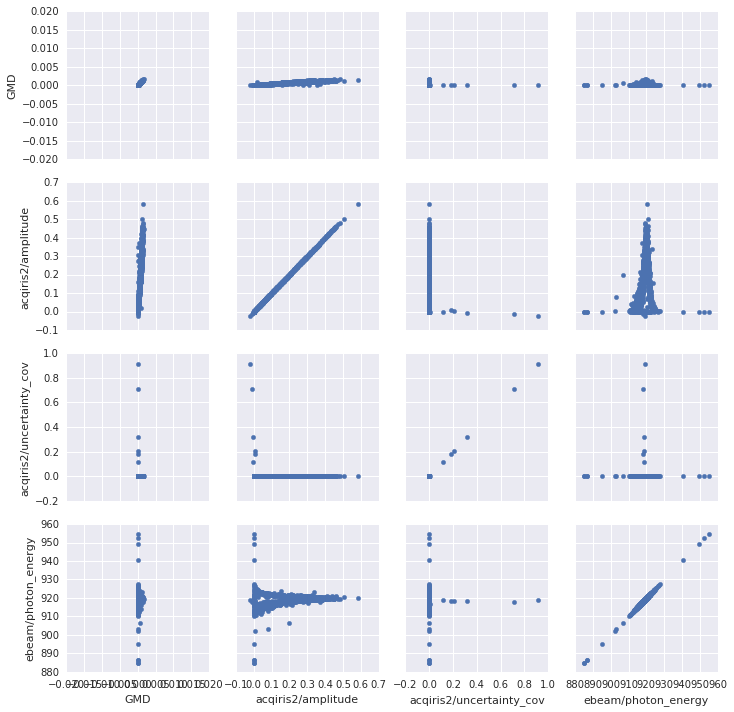

In [28]:
# The columns we will be plotting
to_plot = ["GMD", 'acqiris2/amplitude','acqiris2/uncertainty_cov', 'ebeam/photon_energy']
plot_cols = ["GMD", 'acqiris2/amplitude','acqiris2/uncertainty_cov', 'ebeam/photon_energy', 'ebeam/L3_energy','gas_detector/f_11_ENRC','timeToolOpal/time_pixel','timeToolOpal/uncertainty_cov']

g = sns.PairGrid(my_data_frame[to_plot][::100])
g = g.map(plt.scatter)

In [54]:
# Intialize the clusterer
clusterer = hdbscan.HDBSCAN(min_cluster_size=300, min_samples=12, alpha=1.0)
labels = clusterer.fit_predict(my_data_frame)
my_data_frame['labels']=labels

In [55]:
# Number of clusters
n_clusters = len(np.unique(labels))
# Series containing the counts for each cluster
counts = my_data_frame["labels"].value_counts()
# Largest cluster
cluster_max = counts.idxmax()
# Count for the largest cluster
count_max = counts.max()

In [56]:
counts

 5     122490
 7       1735
-1       1407
 1       1302
 9       1238
 4        844
 0        671
 10       658
 3        642
 11       636
 2        595
 8        534
 12       519
 6        312
Name: labels, dtype: int64

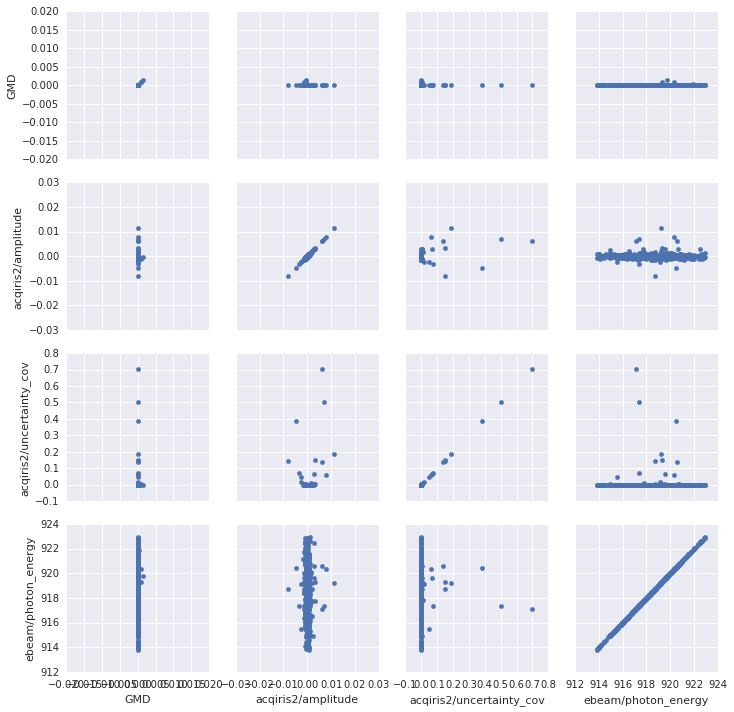

In [60]:
#my_data = nan_to_num(array([my_dict['GMD'],my_dict['acqiris2/amplitude'],
#                 my_dict['acqiris2/uncertainty_cov'],my_dict['ebeam/photon_energy'],
#                  my_dict['ebeam/L3_energy'],my_dict['gas_detector/f_11_ENRC'],
#                 my_dict['timeToolOpal/time_pixel'],my_dict['timeToolOpal/uncertainty_cov'],
#                            my_dict['evr/code_141'],my_dict['evr/code_162'],
#                            my_dict['evr/code_142']])).transpose()

myMask = array(my_data_frame['labels']==2)
g = sns.PairGrid(pd.DataFrame(my_data_frame[to_plot][myMask]))
g = g.map(plt.scatter)